# 教程2: 质量控制与过滤

我们得到的scRNA-seq与scATAC-seq文件仍有大量信息是冗余的，比如有些基因只在极少数细胞中表达，有些细胞表达的基因极少，我们希望得到一些高质量的数据，加速我们后续的计算速度，并节省计算机的内存开支，所以我们需要对数据进行预处理与过滤

In [6]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import episcanpy.api as epi
print('episcanpy(Ver): ',epi.__version__)
import gc
import os
#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')
current_path='/home/leihu/data/analysis/rb_tutorial/'

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.4
episcanpy(Ver):  0.3.2


## 2. scRNA-seq质控

在这里，我们先对scRNA-seq进行处理，我们质控分为三个步骤：

- 1. 去除低表达的细胞与基因
- 2. 去除双细胞（一个油滴两细胞）
- 3. 按照基因读数与线粒体基因的比例过滤细胞

In [2]:
#读取数据
adata=sc.read(current_path+'data/raw_data/RB-rna-Retinoblastoma.h5ad')
adata

AnnData object with n_obs × n_vars = 22048 × 64202
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [3]:
#第一次过滤
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 21896 × 40345
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [4]:
#第二次过滤
sc.external.pp.scrublet(adata) #estimates doublets

Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 8.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.6%


In [5]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 21867 × 40345
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells'
    uns: 'scrublet'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

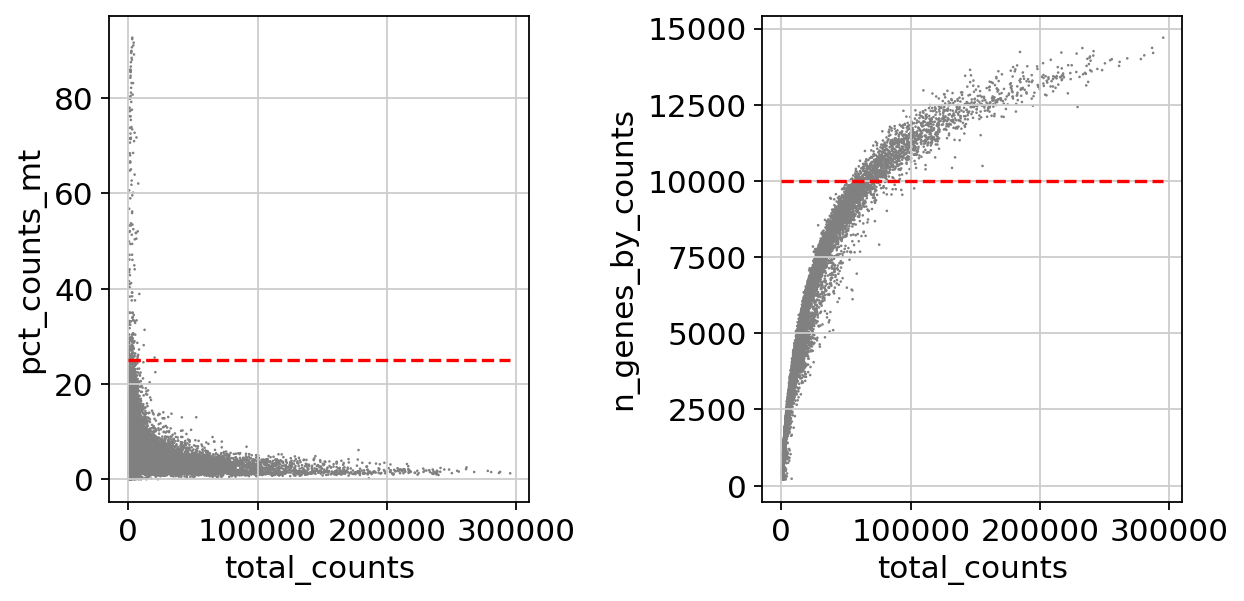

In [9]:
#第三次过滤
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#这里是阈值的选取，我们线粒体基因的比例不超过25%，每个细胞的总表达基因不超过10000个
mito_filter = 25
n_counts_filter = 10000

#绘图
fig, axs = plt.subplots(ncols = 2, figsize = (6,3))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [10]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 20260 × 40345
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [11]:
#保存文件
adata.write_h5ad(current_path+'data/filtered_data/rb_rna_filtered.h5ad',compression='gzip')

## 3. scATAC-seq合并

由于scATAC捕获的feature为`chr:xxx-xxx`格式,所以比对的时候并不能像scRNA-seq一样直接相同合并，我们需要一些其他方式来合并feature

In [11]:
import pandas as pd
import numpy as np
import anndata as ad

def atac_concat_get_index(adata1,adata2):
  import gc
  
  # 数据预处理
  adata1.var.loc[:,'ATAC'] = adata1.var.index
  adata1.var = pd.DataFrame((x.split('_') for x in adata1.var['ATAC']) , index = adata1.var.index , columns = ['chr','chromStart','chromEnd'])
  adata2.var.loc[:,'ATAC'] = adata2.var.index
  adata2.var = pd.DataFrame((x.split('_') for x in adata2.var['ATAC']) , index = adata2.var.index , columns = ['chr','chromStart','chromEnd'])

  # 判断是否出现 不存在某条染色体的情况，如果存在，我们希望染色体较少的一方为adata1（因为后续的分析都是针对adata1为染色体较少的情况进行分析的）
  # 如果出现adata1的染色体比adata2的染色体多，则调换位置
  if len(set(adata1.var.chr))>len(set(adata2.var.chr)):
    adata_chr = adata1
    adata1 = adata2
    adata2 = adata_chr
    Exchange = True #Exchange用于判断调换位置的特殊情况
  else:
    Exchange = False
 

  # 循环函数确定和拆分
  atac_var = adata1.var
  Promoter = adata2.var
  Promoter.loc[:,'chr']=Promoter.loc[:,'chr']+'_'
  Promoter.loc[:,'index_1'] = Promoter.index
  atac_var.loc[:,'chr']=atac_var.loc[:,'chr']+'_'
  atac_var.loc[:,'index_1'] = atac_var.index
  chr	= set(Promoter.chr)

  # 比对函数开始
  ATAC = {}
  PROMOTER = {}
  for x in chr:
    # 染色体拆分
    test = pd.DataFrame(columns=['Length'])
    ATAC[x] = test
    ATAC[x]=atac_var[atac_var.index.str.contains(x)]
    PROMOTER[x] = test
    test = pd.DataFrame(columns=['Length'])
    PROMOTER[x]=Promoter.loc[Promoter['chr'] == x]

    # 输出循环染色体
    print('start %s' % (x))
  
    # 特殊情况处理-判断该条染色体是否为空值,并进行赋值
    if len(ATAC[x].index)==0:
      ATAC[x] = PROMOTER[x]
      ATAC_INDEX = ATAC[x].columns.to_list() + ['overleaf_1','overleaf_2','chromStart_New','chromEnd_New','index_2']
      ATAC[x] = ATAC[x].reindex(columns=ATAC_INDEX, fill_value='retain')
      ATAC[x].loc[:,'index_2'] = ATAC[x].loc[:,'index_1']
      continue
    

    # index赋值
    ATAC_INDEX = ATAC[x].columns.to_list() + ['overleaf_1','overleaf_2','chromStart_New','chromEnd_New','index_2']
    ATAC[x] = ATAC[x].reindex(columns=ATAC_INDEX, fill_value='')
    
    # 函数主循环体
    for i in range(0,len(PROMOTER[x].chromEnd)):
      left = 0
      right = len(ATAC[x].chromEnd)-1
      target_Start = int(PROMOTER[x].chromStart.iloc[i])
      target_End = int(PROMOTER[x].chromEnd.iloc[i])


      while(left<=right):
        # 中位数表示 #
        midIndex = round(int((left+right)/2))
        midValue_Start = int(ATAC[x].chromStart.iloc[midIndex])
        midValue_End = int(ATAC[x].chromEnd.iloc[midIndex])
        # 三次condition判断 #

        if (target_Start > midValue_End) :
          left = midIndex+1

        elif (target_End < midValue_Start):
          right = midIndex-1
        else:
          Length = target_End - target_Start
          ATAC[x].loc[:,'overleaf_1'].iloc[midIndex] = (target_Start - midValue_End)/Length
          ATAC[x].loc[:,'overleaf_2'].iloc[midIndex] = (midValue_Start - target_End)/Length
          list = [midValue_Start,midValue_End,target_Start,target_End]
          ATAC[x].loc[:,'chromStart_New'].iloc[midIndex] = min(list)
          ATAC[x].loc[:,'chromEnd_New'].iloc[midIndex] = max(list)
          ATAC[x].loc[:,'index_2'].iloc[midIndex] = PROMOTER[x].index[i]
          break
 
  # 拼接dataframe
  ATAC_Promoter = pd.DataFrame()
  for i in chr:
    ATAC_Promoter = pd.concat([ATAC_Promoter,ATAC[i],],axis=0)
    
  # 删除未比对上序列
  ATAC_Promoter = ATAC_Promoter[ATAC_Promoter['overleaf_1']!='']

  # 定义新序列拼接函数
  def indeX(series):
    chr = series["chr"]
    chromStart_New = series["chromStart_New"]
    chromEnd_New = series["chromEnd_New"]
    indeX = chr + str(chromStart_New) +'_' +str(chromEnd_New)
    return indeX

  # 拼接新序列
  ATAC_Promoter.loc[:,'index_new'] = ''
  ATAC_Promoter.loc[:,'index_new'] = ATAC_Promoter.apply(indeX,axis=1)

  # 提取新序列
  pair_index = pd.DataFrame()
  pair_index.loc[:,'overleaf_1'] = ATAC_Promoter.loc[:,'overleaf_1']
  pair_index.loc[:,'overleaf_2'] = ATAC_Promoter.loc[:,'overleaf_2']
  pair_index.loc[:,'index_new'] = ATAC_Promoter.loc[:,'index_new']
  # 若出现adata1调换adata2的特殊情况，则在这里把adata1和adata2再调换回来
  if Exchange==True:
    pair_index.loc[:,'index_1'] = ATAC_Promoter.loc[:,'index_2']
    pair_index.loc[:,'index_2'] = ATAC_Promoter.loc[:,'index_1']
  else:
    pair_index.loc[:,'index_1'] = ATAC_Promoter.loc[:,'index_1']
    pair_index.loc[:,'index_2'] = ATAC_Promoter.loc[:,'index_2']
  # 特殊情况处理-空值染色体
  pair_index.loc[pair_index['overleaf_1']=='retain','index_new'] = pair_index.loc[pair_index['overleaf_1']=='retain','index_1']
  gc.collect()
  return pair_index


def atac_concat_inner(adata1,adata2,pair_index):
  import gc
  
  # 设置基本参数
  adata1.var.loc[:,'ATAC'] = adata1.var.index
  df1 = pd.DataFrame((x.split('_') for x in adata1.var['ATAC']) , index = adata1.var.index , columns = ['chr','chromStart','chromEnd'])
  adata1.var = df1
  adata2.var.loc[:,'ATAC'] = adata2.var.index
  df2 = pd.DataFrame((x.split('_') for x in adata2.var['ATAC']) , index = adata2.var.index , columns = ['chr','chromStart','chromEnd'])
  adata2.var = df2

  # 判断是否存在需要调换位置的情况
  if len(set(adata1.var.chr))>len(set(adata2.var.chr)): 
    Exchange = True #Exchange用于判断调换位置的特殊情况
  else:
    Exchange = False
  
  # 通过overleaf_1的赋值来判断是否存在缺失染色体的情况
  if Exchange==False:
    atac1_new = adata1[:,pair_index[pair_index['overleaf_1']!='retain'].index_1]
    atac1_new.var = pair_index[pair_index['overleaf_1']!='retain']
    atac1_new.var.index = atac1_new.var.index_new
    atac2_new = adata2[:,pair_index.index_2]
    atac2_new.var = pair_index
    atac2_new.var.index = atac2_new.var.index_new

  if Exchange==True:
    atac1_new = adata1[:,pair_index.index_1]
    atac1_new.var = pair_index
    atac1_new.var.index = atac1_new.var.index_new
    atac2_new = adata2[:,pair_index[pair_index['overleaf_1']!='retain'].index_2]
    atac2_new.var = pair_index[pair_index['overleaf_1']!='retain']
    atac2_new.var.index = atac2_new.var.index_new
  
  # 配对
  adata_pair = ad.concat([atac1_new,atac2_new],axis=0,join='outer',fill_value=0)
  adata_pair.obs_names_make_unique()
  adata_pair
  gc.collect()
  return adata_pair

def atac_concat_outer(adata1,adata2,pair_index):
  import gc
  
    # 提取关键参数
  adata1.var.loc[:,'ATAC'] = adata1.var.index
  adata1.var = pd.DataFrame((x.split('_') for x in adata1.var['ATAC']) , index = adata1.var.index , columns = ['chr','chromStart','chromEnd'])
  adata2.var.loc[:,'ATAC'] = adata2.var.index
  adata2.var = pd.DataFrame((x.split('_') for x in adata2.var['ATAC']) , index = adata2.var.index , columns = ['chr','chromStart','chromEnd'])

    # 判断是否存在需要调换位置的情况
  if len(set(adata1.var.chr))>len(set(adata2.var.chr)): 
    Exchange = True #Exchange用于判断调换位置的特殊情况
  else:
    Exchange = False
  
    # 通过overleaf_1的赋值来判断是否存在缺失染色体的情况
  if Exchange==False:
    atac1_new = adata1[:,pair_index[pair_index['overleaf_1']!='retain'].index_1]
    atac1_new.var = pair_index[pair_index['overleaf_1']!='retain']
    atac1_new.var.index = atac1_new.var.index_new
    atac2_new = adata2[:,pair_index.index_2]
    atac2_new.var = pair_index
    atac2_new.var.index = atac2_new.var.index_new

  if Exchange==True:
    atac1_new = adata1[:,pair_index.index_1]
    atac1_new.var = pair_index
    atac1_new.var.index = atac1_new.var.index_new
    atac2_new = adata2[:,pair_index[pair_index['overleaf_1']!='retain'].index_2]
    atac2_new.var = pair_index[pair_index['overleaf_1']!='retain']
    atac2_new.var.index = atac2_new.var.index_new

  # 计算前置数据
  index_list = atac1_new.var
  index_list.index = index_list.index_1
  df_month = pd.DataFrame(columns=['name'])
  df_month.name = adata1.var.index.values
  df_month.index = df_month.name.values
  df_month.drop(['name'],axis=1,inplace=True)
  var_1 = pd.concat([index_list,df_month],join='outer',axis=1).copy()
  var_1 = var_1.fillna('*')
  var_1['name']=var_1.index
  # 替换index
  var_1.loc[var_1['index_1']!='*','name'] = var_1[var_1['index_1']!='*'].index_new.values
  var_1.index = var_1.name
  adata1.var =var_1
  # 输出结果
  adata1.var_name = var_1.index
  
   # 同上
  index_list = atac2_new.var
  index_list.index = index_list.index_2
  df_month = pd.DataFrame(columns=['name'])
  df_month.name = adata2.var.index.values
  df_month.index = df_month.name.values
  df_month.drop(['name'],axis=1,inplace=True)
  var_2 = pd.concat([index_list,df_month],join='outer',axis=1).copy()
  var_2 = var_2.fillna('*')
  var_2['name']=var_2.index
  var_2.loc[var_2['index_1']!='*','name'] = var_2[var_2['index_1']!='*'].index_new.values
  var_2.index = var_2.name
  adata2.var =var_2
  adata2.var_name = var_2.index

  adata_pair = ad.concat([adata1,adata2],axis=0,join='outer',fill_value=0)
  adata_pair.obs_names_make_unique()
  adata_pair

  gc.collect()
  return adata_pair

## scATAC-seq 合并

In [12]:
adata_1 = sc.read(current_path+'data/raw_data/RB-atac-SRR13633766.h5ad')
adata_2 = sc.read(current_path+'data/raw_data/RB-atac-SRR13633772.h5ad')

In [13]:
pair_index = atac_concat_get_index(adata_1,adata_2)

start chrX_
start chr21_
start chr8_
start chr18_
start chr17_
start chr14_
start chr7_
start chr11_
start chr3_
start chr20_
start chr1_
start chr22_
start chr6_
start chrY_
start chr4_
start chr9_
start chr19_
start chr2_
start chr15_
start chr5_
start chr12_
start chr16_
start chr13_
start chr10_


In [14]:
adata_final = atac_concat_outer(adata_1,adata_2,pair_index) #并集

In [16]:
adata_final.write_h5ad(current_path+'data/raw_data/rb_atac_single_raw.h5ad')

## 4. scATAC-seq质控

对scRNA-seq完成质控后，我们对scATAC-seq也进行质量控制，这里我们使用`episcanpy`进行质控，与scRNA-seq类似，scATAC-seq的质控也分为三步

In [17]:
adata=sc.read(current_path+'data/raw_data/rb_atac_single_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 40032 × 296319
    obs: 'Tissue', 'Developmental_Stage'

In [18]:
#第一次过滤，我们把非0的细胞跟peaks筛选出来
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 40032 × 296319
    obs: 'Tissue', 'Developmental_Stage', 'n_genes'
    var: 'n_cells'

In [5]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

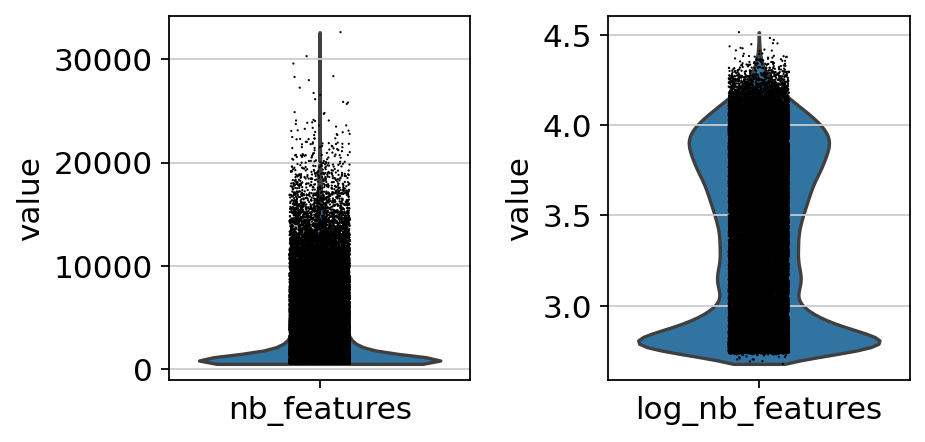

In [7]:
#我们对每个细胞的features的数量进行对数化进行可视化
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
fig, axs = plt.subplots(ncols = 2, figsize = (6,3))
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
epi.pl.violin(adata, ['nb_features'], ax = axs[0], show=False)
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
epi.pl.violin(adata, ['log_nb_features'], ax = axs[1], show=False)
#draw horizontal red lines indicating thresholds.
#axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
#axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

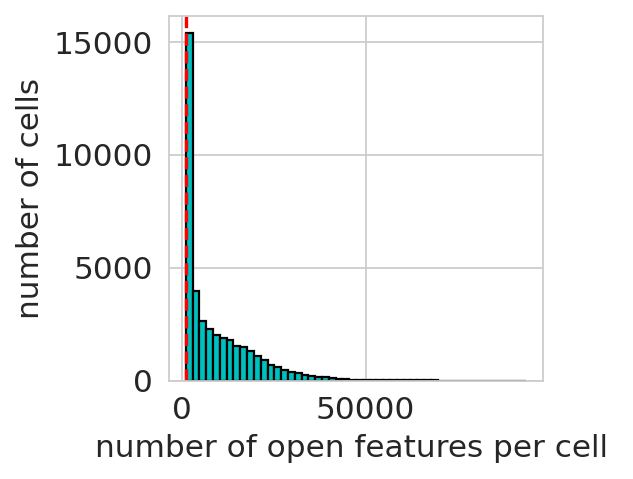

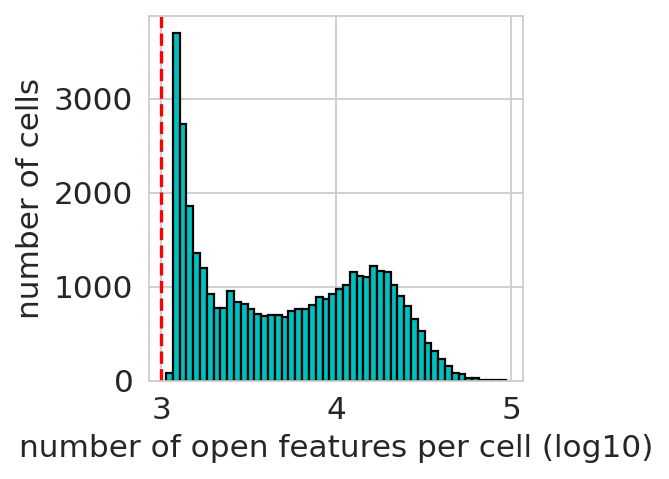

In [37]:
# set a minimum number of cells to keep 
min_features = 1000
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features)
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features)
fig.tight_layout()
plt.show()

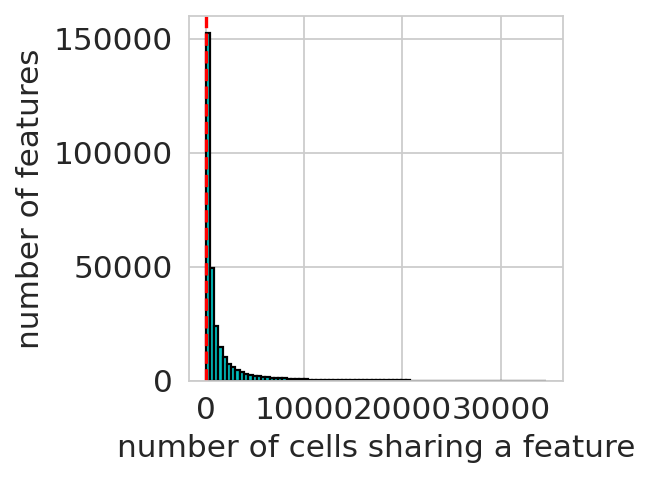

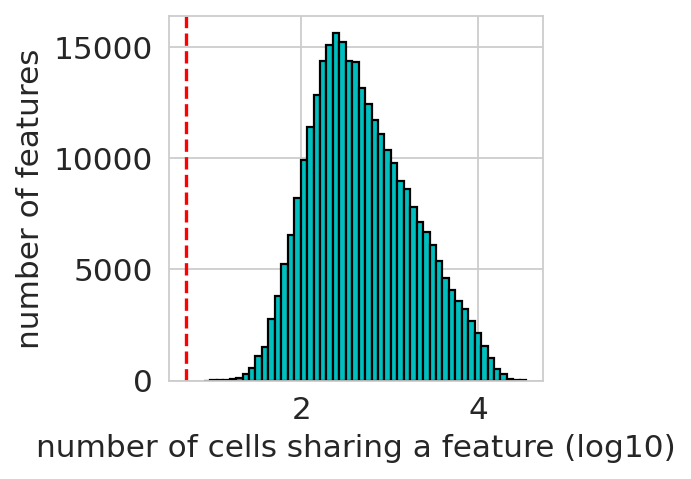

In [38]:
# minimum number of cells sharing a feature
#我们设定每个细胞至少有5个共同的peaks
min_cells = 5
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells)
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells)

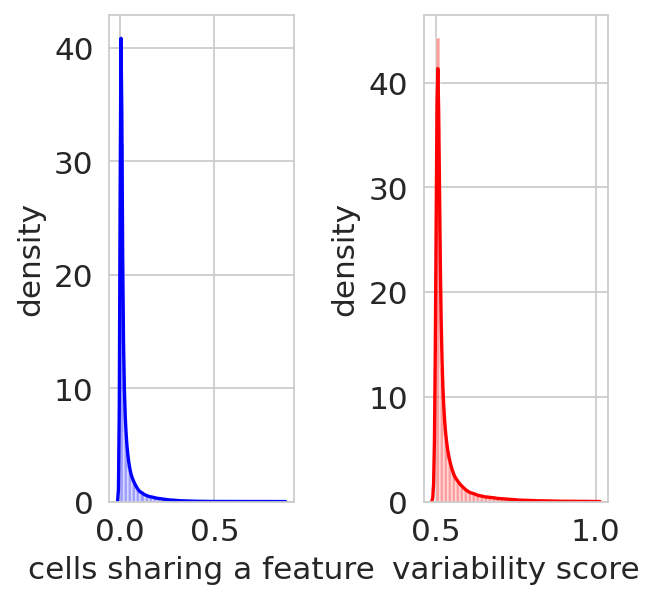

In [39]:
epi.pp.cal_var(adata)

In [41]:
#第二次过滤
#我们希望scATAC-seq中每个细胞至少表达2000个peaks，不超过15000个peaks
epi.pp.filter_cells(adata, min_features=2000)
epi.pp.filter_cells(adata, max_features=15000)
adata

filtered out 17985 cells that have less than 2000 genes expressed
filtered out 853 cells that have more than 15000 genes expressed


AnnData object with n_obs × n_vars = 21194 × 296334
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [42]:
adata.write_h5ad(current_path+'data/filtered_data/rb_atac_filtered.h5ad',compression='gzip')

在后续注释完细胞类型后，我们还会对scATAC-seq进行另一方面的质控